Import libraries.

In [1]:
import pymongo
import footmldb as fdb
import pandas as pd
from pandas.io.json import json_normalize
import json

In [3]:
def connect_db(remote=False):
    """
    Connects to learnbet database and returns the database object.
    
    If remote=True this method will connect to the live database on the aws server.
    Work carefully with it, db is live.
    """
    
    if remote:
        with open("db_credentials_remote.json", "r") as file:
            db_config = json.load(file)
    else:
        with open("db_credentials.json", "r") as file:
            db_config = json.load(file)
            
    uri = 'mongodb://%s:%s@%s/%s' % \
          (db_config['username'], 
           db_config['password'], 
           db_config['DB_IP'], 
           db_config['DB_name'])
    
    client = pymongo.MongoClient(uri)
    db = client.get_database()
    
    return db

In [4]:
db_ = connect_db(remote=True)

In [5]:
print(db_.matches.count())

C:\Users\mp3213\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


583


In [10]:
m = db_.matches.find_one({'team_home': 'Atalanta', 'team_away': 'Inter Milan'})
all_odds = m['all_odds']['winner']
for entry in all_odds:
    print("%s | %d " % (entry['datetime'], len(entry['odds'])))

2018-11-04 18:38:33.917000 | 23 
2018-11-04 22:47:08.041000 | 25 
2018-11-05 02:32:30.810000 | 25 
2018-11-05 06:28:30.313000 | 25 
2018-11-05 10:22:53.594000 | 25 
2018-11-05 14:12:59.298000 | 25 
2018-11-05 18:05:29.072000 | 26 
2018-11-05 21:45:21.022000 | 25 
2018-11-06 01:56:16.616000 | 25 
2018-11-06 06:07:11.849000 | 25 
2018-11-06 10:07:01.188000 | 26 
2018-11-06 14:08:24.652000 | 26 
2018-11-06 18:09:16.552000 | 27 
2018-11-06 23:53:53.109000 | 27 
2018-11-07 04:01:09.574000 | 27 
2018-11-07 08:07:17.579000 | 26 
2018-11-07 12:20:02.371000 | 27 
2018-11-07 16:21:33.617000 | 27 
2018-11-07 22:34:26.856000 | 27 
2018-11-08 04:56:29.703000 | 27 
2018-11-08 10:46:32.499000 | 26 
2018-11-08 17:01:27.310000 | 27 
2018-11-08 23:11:21.211000 | 27 
2018-11-09 04:56:32.018000 | 27 
2018-11-09 10:54:16.892000 | 27 
2018-11-09 16:58:36.255000 | 27 
2018-11-09 22:35:35.359000 | 27 
2018-11-10 04:35:05.522000 | 27 
2018-11-10 10:17:11.727000 | 27 
2018-11-10 16:04:36.167000 | 27 
2018-11-10

# Get matches (list / dataframe)

Get all matches.

In [13]:
def get_db_matches():
    """
    Get a list of all matches from db
    """
    
    # Get matches from db, sorted by `match_datetime`
    db_ = connect_db(remote=True)
    ms = list(db_.matches.find())  # .sort("match_datetime")
    return ms


def get_matches_df():
    """
    Get a pandas dataframe of all matches in db
    """
    
    ms = get_db_matches()
    df_orig = json_normalize(ms)
    df = df_orig
    df['goals_home'] = df['result.fulltime.goals_home']
    df['goals_away'] = df['result.fulltime.goals_away']
    df = df.drop(['odds_link', '_id', 'result.extratime.goals_away', 'result.extratime.goals_home', 'result.halftime.goals_away', 'result.halftime.goals_home', 'result.fulltime.goals_away', 'result.fulltime.goals_home'], axis=1)
    df['num_odds'] = [len(a) for a in df['all_odds.winner']]
    return df

In [ ]:
df = get_matches_df()
len(df)

Print a few matches:

Get one match and analyse it.

# Get bookies stats

Using the `get_bookie_stats` method, I can see bookies' activity and choose the most active ones to get data from.

In [52]:
def get_bookie_stats():

    from collections import Counter
    ms = get_db_matches()

    bookies_count = {}
    bookies_list_global = []

    for m in ms:

        # Go through all odds and create a set of unique bookies appearing in each match
        bookies_set = set()
        all_odds = m['all_odds']['winner']
        if all_odds is None:
            continue
            
        all_odds = [item for item in all_odds if item is not None]
        all_odds = sorted(all_odds, key=lambda item:item['datetime'])
        for entry in all_odds:
            bookies_list = [e['bookie'] for e in entry['odds']]
            bookies_set.update(bookies_list)
            bookies_list_global.extend(bookies_list)

        # Update bookie appearance count for all matches
        for bookie in bookies_set:
            if bookie in bookies_count.keys():
                bookies_count[bookie] += 1
            else:
                bookies_count[bookie] = 1

    # Get bookies from most to least common appearances
    counter_all_appear = Counter(bookies_list_global)
    
    dict_all = {}
    dict_all['match_appear'] = bookies_count
    dict_all['all_appear'] = counter_all_appear
    
    df = pd.DataFrame(dict_all)
    df.sort_values(by='match_appear', inplace=True, ascending=False)
    return df


In [53]:
df = get_bookie_stats()
df

,match_appear,all_appear
Bet Victor,557,15049
888sport,556,14683
Unibet,556,14818
10Bet,554,14924
Marathon Bet,545,14409
Sportingbet,542,14034
Betway,538,14448
188Bet,532,14135
Betfred,528,14556
Betfair,526,14565


In [56]:
# The following list belongs to the old db. Compare with the new one above

# df = get_bookie_stats()
# df
# 	all_appear	match_appear
# Bet 365	12831	902
# Sky Bet	11390	851
# Ladbrokes	10396	826
# William Hill	9985	802
# Marathon Bet	9537	780
# Betfair Sportsbook	9314	770
# SunBets	9176	764
# Paddy Power	9056	751
# Unibet	8967	748
# Coral	8848	743
# Betfred	8745	740
# Boylesports	8652	732
# Black Type	8521	723
# Betstars	8325	714
# Betway	8207	706
# BetBright	8062	695
# 10Bet	7819	685
# Sportingbet	7470	665
# 188Bet	7070	637
# 888sport	6518	605
# Bet Victor	5946	566
# Sportpesa	5261	519
# Betfair	4424	446
# Betdaq	3492	386
# Winner	1593	321
# Matchbook	2614	307
# Smarkets	1843	231
# Spreadex	1334	194

In [54]:
def plot_odds_winner(home_team, away_team):
    """
    Retrieves match directly from the db, creates a dataframe of odds and plots odds over time.
    
    todo: creating the dataframe should be done in a different function
    """
    
    import matplotlib.pyplot as plt
    
    # Retrieve match from database
    m = db_.matches.find_one({'team_home': home_team, 'team_away': away_team})
    if m is None:
        return "Match not found"
    
    # Create a dataframe of match odds
    df = pd.DataFrame()
    winner = m['all_odds']['winner']
    odds2 = []
    for odds in winner:
#         print(odds)
        for odd in odds['odds']:
            odd['datetime'] = odds['datetime']
            odds2.append(odd)
    df = pd.DataFrame(odds2, columns=['datetime', '1', '2', '0', 'bookie'])
    df['1'] = df['1'].astype('float32')
    df['2'] = df['2'].astype('float32')
    df['0'] = df['0'].astype('float32')
    df['bookie'] = df['bookie'].astype('str')

    # Filter over the following bookies
    bookies_to_plot = ['Bet 365', 
                       'Sky Bet', 
                       'Ladbrokes', 
                       "William Hill", 
                       "Marathon Bet", 
                       "Betfair Sportsbook", 
                       "SunBets", 
                       "Paddy Power",
                       "Unibet",
                       "Coral",
                       "Betfred",
                       "Bet Victor"]
    filters = [(df.bookie == "Bet 365") | (df.bookie == "Bet365"), 
          (df.bookie == "Sky Bet") | (df.bookie == "Skybet"), 
          (df.bookie == "Ladbrokes"),
          (df.bookie == "William Hill"),
          (df.bookie == "Marathon Bet"), 
          (df.bookie == "Betfair Sportsbook"),
          (df.bookie == "SunBets"),
          (df.bookie == "Paddy Power"), 
          (df.bookie == "Unibet"),
          (df.bookie == "Coral"),
          (df.bookie == "Betfred"),
          (df.bookie == "Bet Victor")]
    
    # Plot
    fig, ax = plt.subplots(3, 1, figsize=(15,10))
    fig.fig_size = (22,10)
    for filter_, bookie in zip(filters, bookies_to_plot):
        ax[0].plot(df[filter_].datetime, df[filter_]['1'], 'o-', label=bookie)
        ax[0].set_title("Home win")
        ax[1].plot(df[filter_].datetime, df[filter_]['0'], 'o-', label=bookie)
        ax[1].set_title("Draw")
        ax[2].plot(df[filter_].datetime, df[filter_]['2'], 'o-', label=bookie)
        ax[2].set_title("Away win")
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    ax[2].legend(loc='lower left')
    fig.suptitle("%s | %s - %s | %s" % (str(m['match_datetime']), m['team_home'], m['team_away'], m['result']['score']), fontsize=16)
    plt.show()
    print("Last odds collected at: %s" % df[filter_].datetime.iloc[-1])
    
# plot_odds_winner("Sassuolo", "Lazio")

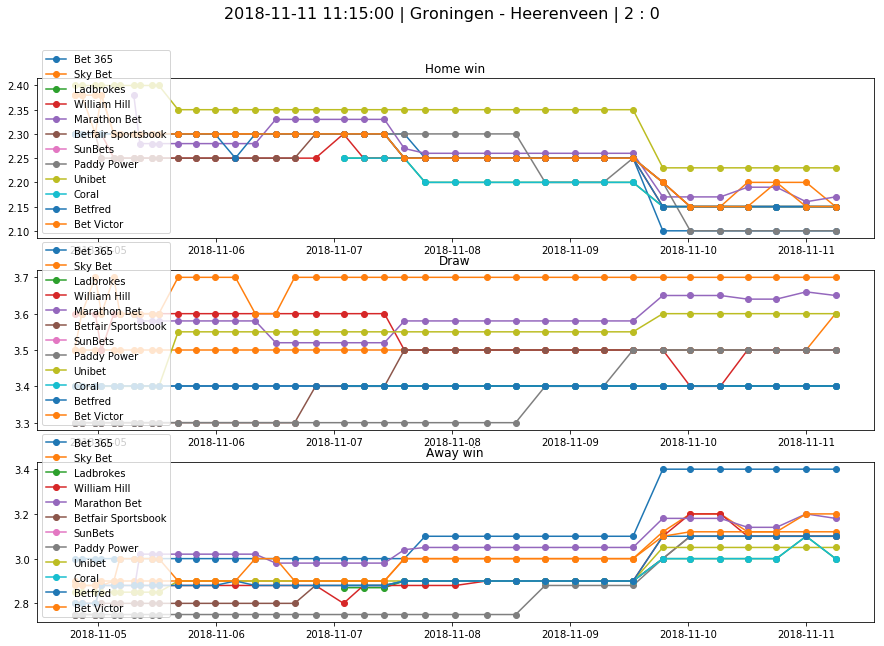

Last odds collected at: 2018-11-11 06:00:07.384000


In [55]:
plot_odds_winner("Groningen", "Heerenveen")

## Update Oct 2018

In [59]:
df = get_bookie_stats()
df.head()

,match_appear,all_appear
Bet Victor,557,15049
888sport,556,14683
Unibet,556,14818
10Bet,554,14924
Marathon Bet,545,14409
